<a href="https://colab.research.google.com/github/roshan-varadhan/spotify-playlist-recommender/blob/main/spotify_playlist_recommendations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Importing Libraries**

In [1]:
!pip install spotipy
!pip install python-dotenv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.1/252.1 kB 4.3 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import time
import os
from dotenv import load_dotenv
from pathlib import Path

# Connecting to Spotify

In [4]:
#Authentication
load_dotenv(dotenv_path=Path('/content/variables.env'))
cid = os.getenv('CLIENT_ID')
secret = os.getenv('CLIENT_SECRET')

client_credentials_mgmt = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager = client_credentials_mgmt)

## Playlist Dataframe

In [38]:
playlist_link = input("Enter the playlist link: ")

# Extract playlist URI from the link
playlist_URI = playlist_link.split("/")[-1].split("?")[0]

# Function to handle retries
def fetch_with_retry(func, *args, retries=5, delay=1, backoff=2, **kwargs):
    for i in range(retries):
        try:
            return func(*args, **kwargs)
        except spotipy.exceptions.SpotifyException as e:
            if e.http_status == 429:
                retry_after = int(e.headers.get('Retry-After', delay))
                print(f"Rate limited. Retrying in {retry_after} seconds...")
                time.sleep(retry_after)
                delay *= backoff
            else:
                raise e
    raise Exception("Max retries exceeded")

# Fetch playlist details
playlist_details = fetch_with_retry(sp.playlist, playlist_URI)

# Get playlist name and user display name
playlist_name = playlist_details['name']
user_display_name = playlist_details['owner']['display_name']

# Fetch playlist tracks
tracks = fetch_with_retry(sp.playlist_tracks, playlist_URI)["items"]

# Extract track details
track_uris = [item["track"]["uri"] for item in tracks]

# Batch URIs for audio features
def get_audio_features(track_uris):
    audio_features = []
    for i in range(0, len(track_uris), 100):
        batch = track_uris[i:i+100]
        features = fetch_with_retry(sp.audio_features, batch)
        audio_features.extend(features)
    return audio_features

# Fetch audio features for the tracks
audio_features = get_audio_features(track_uris)

# Combine track details with audio features
track_data = []
for item, features in zip(tracks, audio_features):
    if features:
      track = item["track"]
      track_name = track["name"]
      artist_name = track["artists"][0]["name"]  # Assuming the first artist is the main artist
      track_uri = track["uri"]

      # Fetch audio features for the track
      audio_features = sp.audio_features(track_uri)[0]
      danceability = audio_features['danceability']
      energy = audio_features['energy']
      liveness = audio_features['liveness']
      key = audio_features['key']
      mode = audio_features['mode']
      loudness = audio_features['loudness']
      speechiness = audio_features['speechiness']
      acousticness = audio_features['acousticness']
      instrumentalness = audio_features['instrumentalness']
      valence = audio_features['valence']
      tempo = audio_features['tempo']

      track_data.append([track_name, artist_name, danceability, energy, liveness, key, mode, loudness, speechiness, acousticness, instrumentalness, valence, tempo])

# Create a DataFrame
df_playlist = pd.DataFrame(track_data, columns=["Track Name", "Artist", "Danceability", "Energy", "Liveness","Key","Mode","Loudness","Speechiness","Acousticness","Instrumentalness","Valence", "Tempo"])
df_playlist.head()

Enter the playlist link: https://open.spotify.com/playlist/7hgwhIag4TeIX5t0Okwsbk?si=5b74929c4938458c


,Track Name,Artist,Danceability,Energy,Liveness,Key,Mode,Loudness,Speechiness,Acousticness,Instrumentalness,Valence,Tempo
0,Holy Grail,JAY-Z,0.676,0.534,0.256,2,0,-6.901,0.0831,0.0594,0.000009,0.156,145.082
1,All Of The Lights,Kanye West,0.531,0.803,0.176,1,1,-3.284,0.0717,0.0796,0.000017,0.221,142.113
2,Pieces (feat. 50 Cent),Tory Lanez,0.512,0.749,0.094,1,1,-7.875,0.6850,0.2720,0.000000,0.656,80.389
3,Forever,Drake,0.415,0.926,0.256,5,0,-1.304,0.3740,0.2530,0.000000,0.542,158.423
4,Right Above It,Lil Wayne,0.345,0.841,0.578,3,0,-4.348,0.3670,0.0435,0.000000,0.461,72.351


## Loading the Data into a Pandas DataFrame

In [39]:
df = pd.read_csv("playlist_2010to2023.csv", encoding='latin-1')
df.dropna(inplace=True)
# Drop Unnecessary Columns
df.drop(['year','artist_genres','playlist_url','track_id','track_popularity','artist_id','artist_popularity','time_signature', 'duration_ms'], axis=1, inplace=True)
df.head()


,track_name,album,artist_name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,Oops!...I Did It Again,Oops!... I Did It Again,Britney Spears,0.751,0.834,1,-5.444,0,0.0437,0.3000,0.000018,0.3550,0.894,95.053
1,All The Small Things,Enema Of The State,blink-182,0.434,0.897,0,-4.918,1,0.0488,0.0103,0.000000,0.6120,0.684,148.726
2,Breathe,Breathe,Faith Hill,0.529,0.496,7,-9.007,1,0.0290,0.1730,0.000000,0.2510,0.278,136.859
3,It's My Life,Crush,Bon Jovi,0.551,0.913,0,-4.063,0,0.0466,0.0263,0.000013,0.3470,0.544,119.992
4,Bye Bye Bye,No Strings Attached,*NSYNC,0.610,0.926,8,-4.843,0,0.0479,0.0310,0.001200,0.0821,0.861,172.638


## Dropping Features and Combining Data

In [40]:
# Create a new DataFrame with only necessary columns
dropped_df = df[['danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo']]
dropped_df_playlist = df_playlist.drop(['Track Name', 'Artist'], axis=1)


In [42]:
# Congregate playlist averages into one representative 'song' to be used for comparison
# Convert column names to lowercase to match expected keys
dropped_df_playlist.columns = dropped_df_playlist.columns.str.lower()

means= dropped_df_playlist.mean()
dropped_df.loc[len(dropped_df.index)] = means
df.loc[len(df.index)] = [playlist_name,'', user_display_name, means['danceability'], means['energy'], means['key'], means['loudness'], means['mode'], means['speechiness'], means['acousticness'], means['instrumentalness'], means['liveness'], means['valence'], means['tempo']]

<ipython-input-42-6cde4d6bdcd8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dropped_df.loc[len(dropped_df.index)] = means


,track_name,album,artist_name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,Oops!...I Did It Again,Oops!... I Did It Again,Britney Spears,0.751,0.834,1.0,-5.444,0.0,0.0437,0.3000,0.000018,0.3550,0.894,95.053
1,All The Small Things,Enema Of The State,blink-182,0.434,0.897,0.0,-4.918,1.0,0.0488,0.0103,0.000000,0.6120,0.684,148.726
2,Breathe,Breathe,Faith Hill,0.529,0.496,7.0,-9.007,1.0,0.0290,0.1730,0.000000,0.2510,0.278,136.859
3,It's My Life,Crush,Bon Jovi,0.551,0.913,0.0,-4.063,0.0,0.0466,0.0263,0.000013,0.3470,0.544,119.992
4,Bye Bye Bye,No Strings Attached,*NSYNC,0.610,0.926,8.0,-4.843,0.0,0.0479,0.0310,0.001200,0.0821,0.861,172.638


In [51]:
# Normalizing numerical feature columns
numerical_columns = ['loudness', 'tempo','key']

# Create a copy of the dropped_df
final_df = dropped_df

# Apply min-max scaling to the selected numerical feature columns
final_df[numerical_columns] = (dropped_df[numerical_columns] - dropped_df[numerical_columns].min()) / (dropped_df[numerical_columns].max() - dropped_df[numerical_columns].min())

# Display the finalized df
final_df.head()

<ipython-input-51-6a2f76be6db3>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df[numerical_columns] = (dropped_df[numerical_columns] - dropped_df[numerical_columns].min()) / (dropped_df[numerical_columns].max() - dropped_df[numerical_columns].min())


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,Cluster,pca_1,pca_2
0,0.751,0.834,0.090909,0.751908,0.0,0.0437,0.3000,0.000018,0.3550,0.894,0.232262,6,0.547381,-0.465898
1,0.434,0.897,0.000000,0.777159,1.0,0.0488,0.0103,0.000000,0.6120,0.684,0.588095,5,-0.470273,-0.410766
2,0.529,0.496,0.636364,0.580865,1.0,0.0290,0.1730,0.000000,0.2510,0.278,0.509421,3,-0.407858,0.215656
3,0.551,0.913,0.000000,0.818204,0.0,0.0466,0.0263,0.000013,0.3470,0.544,0.397599,1,0.516279,-0.561080
4,0.610,0.926,0.727273,0.780759,0.0,0.0479,0.0310,0.001200,0.0821,0.861,0.746622,9,0.634915,0.170083


# Data Analyzation

## Clustering the Data

In [45]:
# Function that works out optimum number of clusters
def optimise_k_means(data, max_k):
    means = []
    inertias = []

    for k in range(1, max_k+1):
        kmeans = KMeans(n_clusters=k, n_init=max_k)
        kmeans.fit(data)

        means.append(k)
        inertias.append(kmeans.inertia_)

    # Generate the elbow plot
    plt.figure(figsize=(10, 5))  # Create a new figure
    plt.plot(means, inertias, 'o-')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.grid(True)
    plt.show()

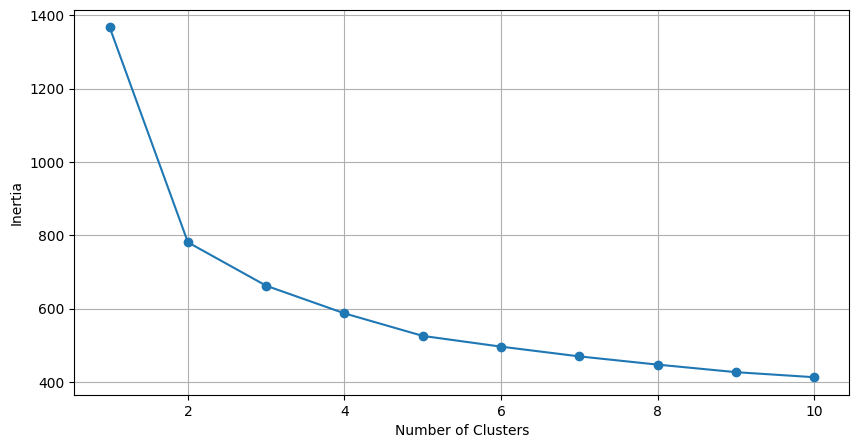

In [46]:
optimise_k_means(final_df, 10)

## Applying K-Means Clustering

In [47]:
# Initialize a KMeans model with 4 clusters
kmeans = KMeans(n_clusters=10, n_init='auto')

# Fit the KMeans model to the data in 'final_df'
kmeans.fit(final_df)

# Assign cluster labels to each data point and add the 'Cluster' column to the original DataFrame
df['Cluster'] = kmeans.labels_
final_df['Cluster'] = kmeans.labels_

<ipython-input-47-c34dd9709eb8>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['Cluster'] = kmeans.labels_


## Model Visualization

<ipython-input-48-298cb5ff5d61>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['pca_1'] = reduced_features[:, 0]
<ipython-input-48-298cb5ff5d61>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['pca_2'] = reduced_features[:, 1]


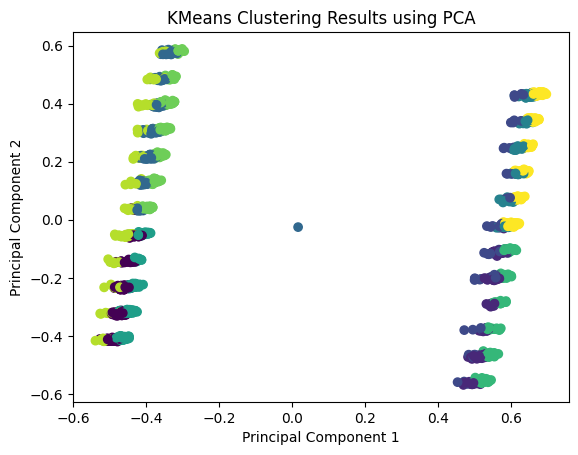

In [48]:
# Perform PCA for dimensionality reduction
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(final_df.drop('Cluster', axis=1)) # Exclude the cluster labels

# Add the reduced components to the DataFrame
final_df['pca_1'] = reduced_features[:, 0]
final_df['pca_2'] = reduced_features[:, 1]

# Create a scatter plot
plt.scatter(final_df['pca_1'], final_df['pca_2'], c=final_df['Cluster'], cmap='viridis')
plt.title('KMeans Clustering Results using PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

## Song Recommendations

In [49]:
def find_song_recommendation(track_name, df):
    try:
        # Attempt to find the index of the first occurence of 'track_name' in the 'Track' column of 'df'
        track_index = df[df['track_name'] == track_name].index[0]

        # Create a filter to select rows in 'df' that belong to the same cluster as the provided track
        filter = (df['Cluster'] == df.loc[track_index]['Cluster'])

        # Apply the filter to 'df' to get a DataFrame containing songs from the same cluster
        filtered_df = df[filter]

        # Generate song recommendations by randomly selecting tracks from the same cluster
        for i in range(50):
            # Randomly sample a track from the shuffled DataFrame
            recommendation = filtered_df.sample()
            # Print the recommended track's title and artist
            print("'" + recommendation.iloc[0]['track_name'] + "' by " + recommendation.iloc[0]['artist_name'])
    except:
      print("Track not found in the dataset.")

In [50]:
find_song_recommendation(playlist_name, df)

'First Class' by Jack Harlow
'Holy (feat. Chance The Rapper)' by Justin Bieber
'i'm so tired...' by Lauv
'Make Me Better' by Fabolous
'Dick (feat. Doja Cat)' by StarBoi3
'Passionfruit' by Drake
'Marry You' by Bruno Mars
'All I Do Is Win (feat. T-Pain, Ludacris, Snoop Dogg & Rick Ross)' by DJ Khaled
'Coming Home' by Diddy - Dirty Money
'Womanizer' by Britney Spears
'Breathe' by Faith Hill
'Yellow' by Coldplay
'Picture (feat. Sheryl Crow)' by Kid Rock
'Rise' by GABRIELLE
'Diamonds From Sierra Leone - Remix' by Kanye West
'Steady, As She Goes' by The Raconteurs
'Fast Car' by Jonas Blue
'Diamonds From Sierra Leone - Remix' by Kanye West
'Big Girls Don't Cry (Personal)' by Fergie
'Keep Holding On' by Avril Lavigne
'In My Mind' by Dynoro
'Galvanize' by The Chemical Brothers
'Over' by Drake
'Shape of My Heart' by Backstreet Boys
'This Is What It Feels Like' by Armin van Buuren
'Starboy' by The Weeknd
'A Moment Like This' by Kelly Clarkson
'we fell in love in october' by girl in red
'Not Over 